In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load and preprocess data
dataset = pd.read_csv('data.csv',
                      chunksize=100000,    # Read in chunks of 100,000 rows
                      on_bad_lines='skip', # Skip bad lines
                      engine='python')
# Concatenate all the chunks into a single DataFrame
data = pd.concat(dataset)

In [3]:
# Define the column names and assign them to the DataFrame
data.columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes',
    'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
    'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
    'su_attempted','num_root', 'num_file_creations', 'num_shells', 
    'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate',
    'srv_serror_rate','rerror_rate', 'srv_rerror_rate','same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
    'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type'# Add this missing column name
]

In [4]:
# Clean up `attack_type` values to remove any trailing periods or spaces
data['attack_type'] = data['attack_type'].str.strip().str.replace('.', '', regex=False)

# Define the mapping of specific attack types to broader categories
attack_classes = {
    'normal': 'Normal',
    
    # Probe attacks
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 
    'mscan': 'Probe', 'saint': 'Probe',
    
    # DoS attacks
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 
    'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 
    'udpstorm': 'DoS',
    
    # U2R attacks
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 
    'xterm': 'U2R', 'ps': 'U2R',
    
    # R2L attacks
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 
    'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'snmpgetattack': 'R2L', 
    'snmpguess': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L'
}

# Map specific attack types to broader categories
data['attack_type'] = data['attack_type'].apply(lambda x: attack_classes.get(x, 'Unknown'))

# Verify the transformation
print(data['attack_type'].value_counts())


attack_type
DoS       3883370
Normal     972779
Probe       41102
R2L          1126
U2R            52
Name: count, dtype: int64


In [6]:
data['attack_type']

0          Normal
1          Normal
2          Normal
3          Normal
4          Normal
            ...  
4898424    Normal
4898425    Normal
4898426    Normal
4898427    Normal
4898428    Normal
Name: attack_type, Length: 4898429, dtype: object

In [7]:
data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')

In [8]:
data.isnull().sum()
print(data.head())

   duration protocol_type service flag  src_bytes  dst_bytes  land  \
0         0           tcp    http   SF        162       4528     0   
1         0           tcp    http   SF        236       1228     0   
2         0           tcp    http   SF        233       2032     0   
3         0           tcp    http   SF        239        486     0   
4         0           tcp    http   SF        238       1282     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                   1   
1               0       0    0  ...                   2   
2               0       0    0  ...                   3   
3               0       0    0  ...                   4   
4               0       0    0  ...                   5   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                     1.0                     0.0   
1                     1.0                     0.0   
2                     1.0                     0.0   
3           

In [9]:
# Check and display the number of duplicates
duplicates_count = data.duplicated().sum()
print(f"Number of duplicate rows found: {duplicates_count}")
# Drop duplicates
data = data.drop_duplicates()

Number of duplicate rows found: 3823448


In [9]:
print(data.shape)
print(data.columns)

(1074981, 42)
Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')


In [10]:
data.info

<bound method DataFrame.info of          duration protocol_type service flag  src_bytes  dst_bytes  land  \
0               0           tcp    http   SF        162       4528     0   
1               0           tcp    http   SF        236       1228     0   
2               0           tcp    http   SF        233       2032     0   
3               0           tcp    http   SF        239        486     0   
4               0           tcp    http   SF        238       1282     0   
...           ...           ...     ...  ...        ...        ...   ...   
4898424         0           tcp    http   SF        212       2288     0   
4898425         0           tcp    http   SF        219        236     0   
4898426         0           tcp    http   SF        218       3610     0   
4898427         0           tcp    http   SF        219       1234     0   
4898428         0           tcp    http   SF        219       1098     0   

         wrong_fragment  urgent  hot  ...  dst_host_srv

In [11]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,...,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06
mean,1.348922e+02,5.837599e+03,4.873736e+03,2.418647e-05,2.735862e-03,3.627971e-05,5.428003e-02,1.460491e-04,6.301209e-01,3.570854e-02,...,1.619740e+02,1.592108e+02,6.700928e-01,4.949942e-02,9.335021e-02,2.173624e-02,1.906599e-01,1.901315e-01,7.954181e-02,7.829742e-02
std,1.321612e+03,2.009627e+06,1.376873e+06,4.917917e-03,8.836031e-02,1.540170e-02,9.974669e-01,1.558120e-02,4.827720e-01,8.232138e+00,...,1.022638e+02,1.098836e+02,4.259519e-01,1.310807e-01,2.298153e-01,5.636334e-02,3.907636e-01,3.913494e-01,2.622007e-01,2.609852e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.000000e+01,1.800000e+01,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.190000e+02,3.320000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,2.240000e+02,2.480000e+02,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.060000e+02,1.721000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,6.000000e-02,4.000000e-02,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


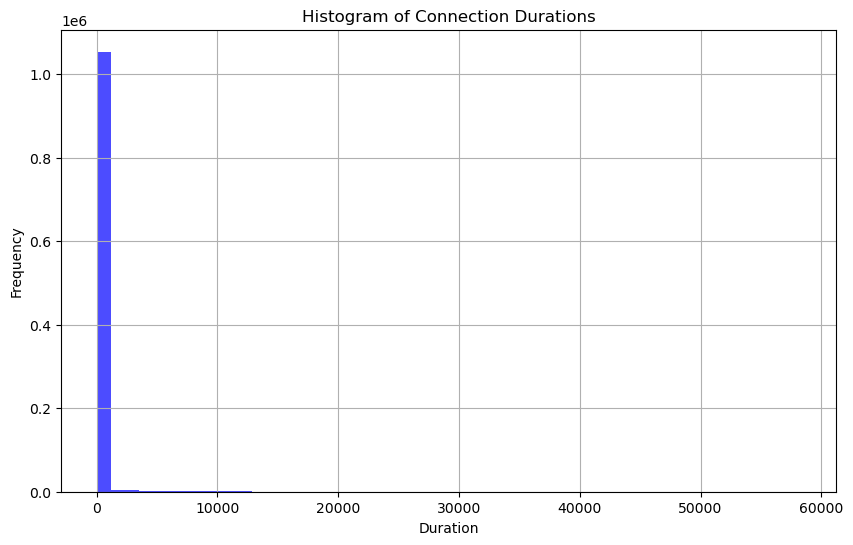

In [20]:

plt.figure(figsize=(10, 6))
plt.hist(data['duration'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Connection Durations')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.grid()
plt.show()

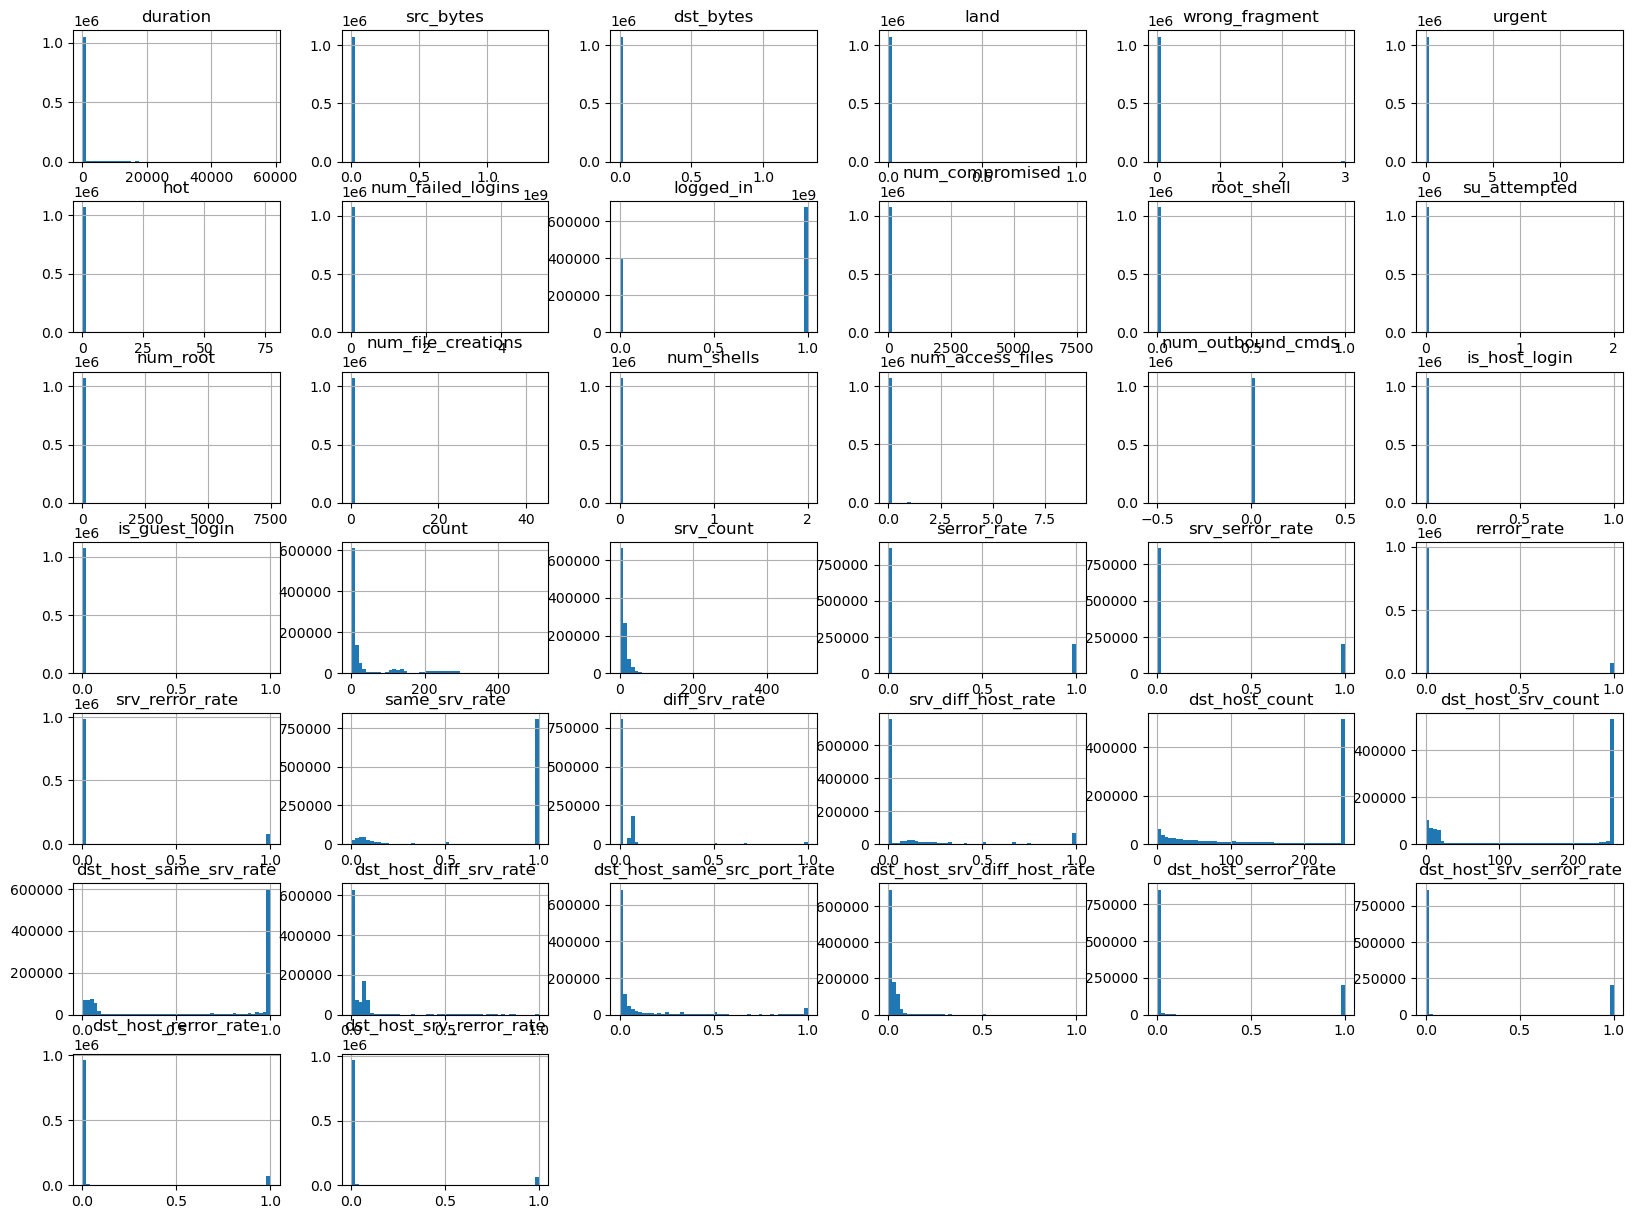

In [12]:
data.hist(bins=50,figsize=(20,15))
plt.show()

In [13]:
# Define a function to plot distributions of categorical features in subplots
def plot_categorical_distributions(data, categorical_features):
    # Create a 2x2 grid for plotting
    fig, axes = plt.subplots(2, 2, figsize=(22, 20))
    fig.tight_layout(h_pad=15, w_pad=10, rect=[0, 0.08, 1, 0.93])

    # Iterate over the features and plot each in a separate subplot
    for i, feature in enumerate(categorical_features):
        row, col = divmod(i, 2)  # Determine subplot position
        data[feature].value_counts().plot(kind='bar', ax=axes[row][col], color='b')
        axes[row][col].set_xlabel(feature, fontsize=18)
        axes[row][col].set_title(f"{feature} on KDD Cup", fontsize=18)
        axes[row][col].tick_params(axis='x', rotation=45)

    print("Category-wise graphical representation")
    plt.show()


Category-wise graphical representation


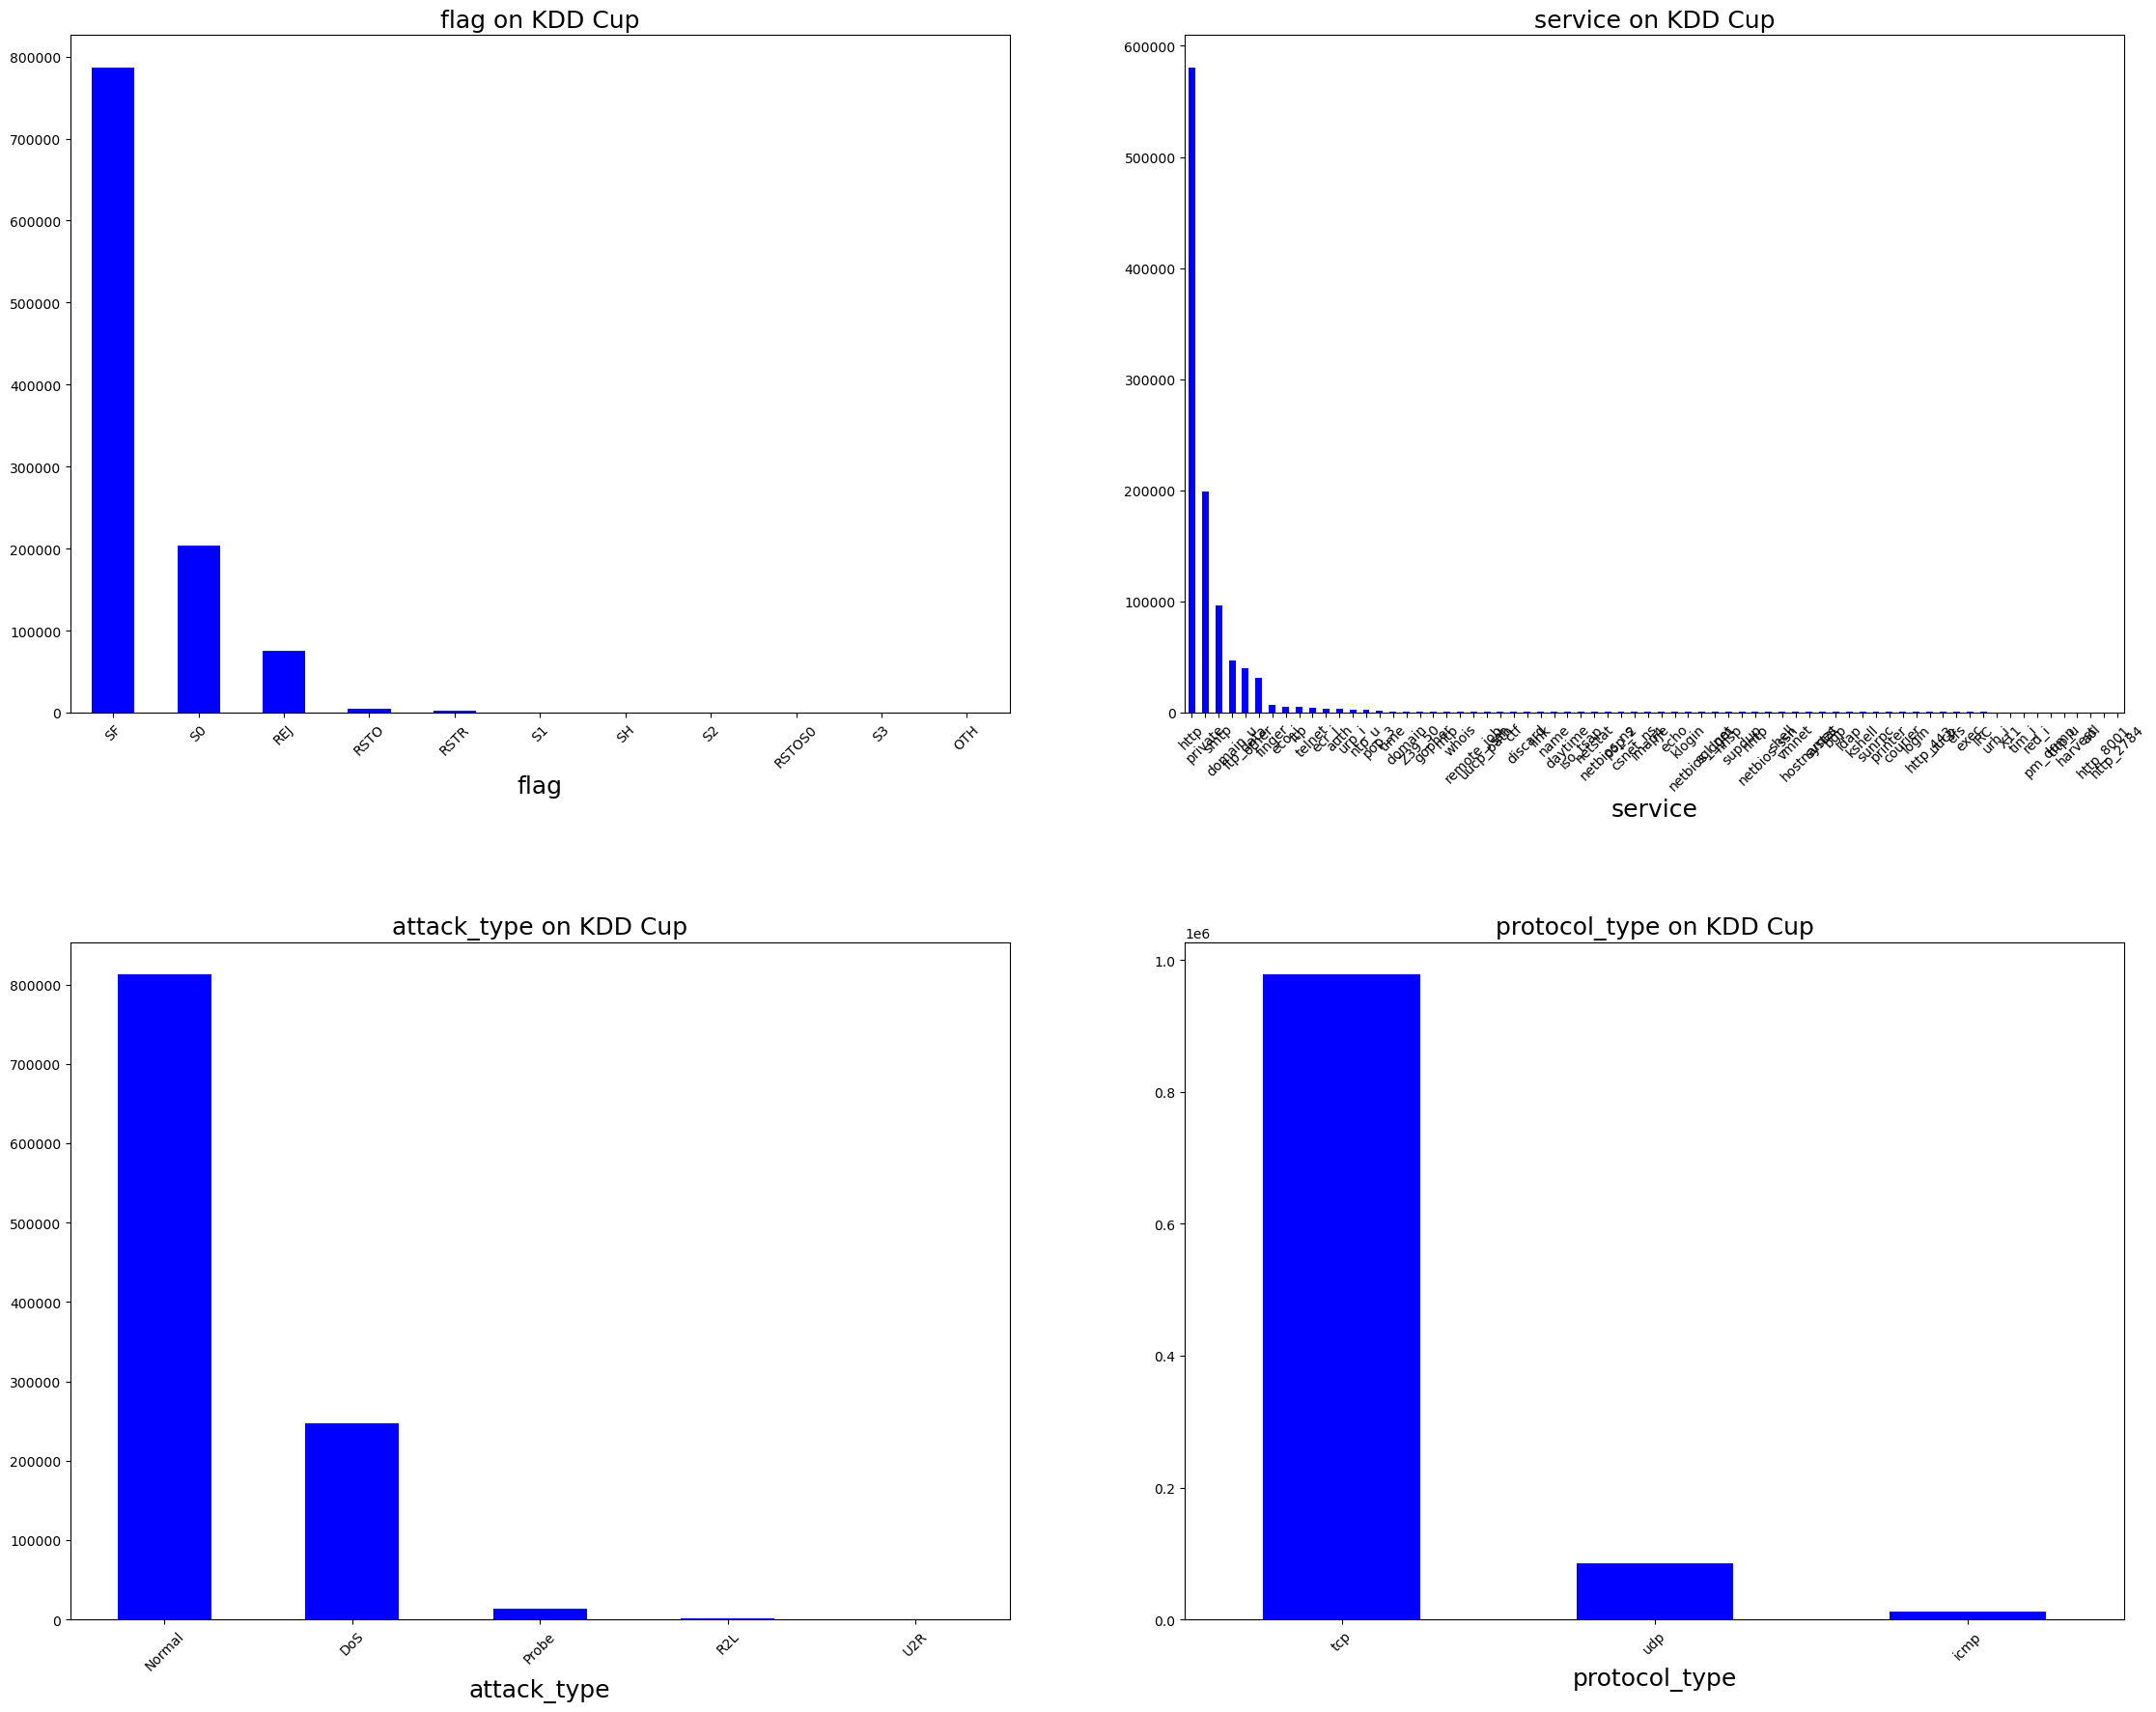

In [14]:
# List of categorical features
categorical_features = ['flag', 'service', 'attack_type', 'protocol_type']

# Call the function with your dataset and the list of categorical features
plot_categorical_distributions(data, categorical_features)

In [15]:
print(data['attack_type'].describe())
print(data['attack_type'].value_counts())

count     1074981
unique          5
top        Normal
freq       812812
Name: attack_type, dtype: object
attack_type
Normal    812812
DoS       247267
Probe      13851
R2L          999
U2R           52
Name: count, dtype: int64


<Axes: >

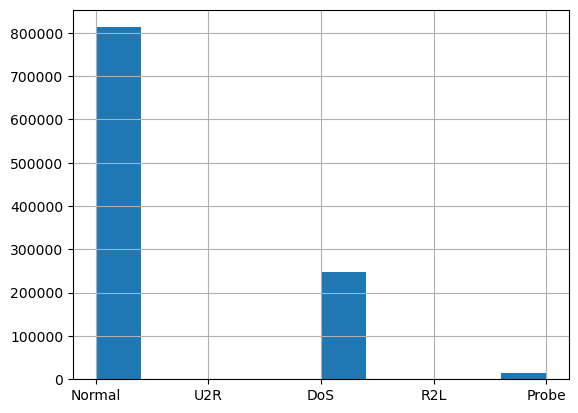

In [16]:
data['attack_type'].hist()

In [17]:
train_set,strat_test_set = train_test_split(data,test_size=0.2,random_state=42,stratify=data['attack_type'])
strat_train_set,strat_val_set=train_test_split(train_set,test_size=0.2,random_state=42,stratify=train_set['attack_type'])

In [18]:
strat_test_set['attack_type'].value_counts() / len(strat_test_set)

attack_type
Normal    0.756118
DoS       0.230022
Probe     0.012884
R2L       0.000930
U2R       0.000047
Name: count, dtype: float64

In [19]:
set = strat_train_set.copy()

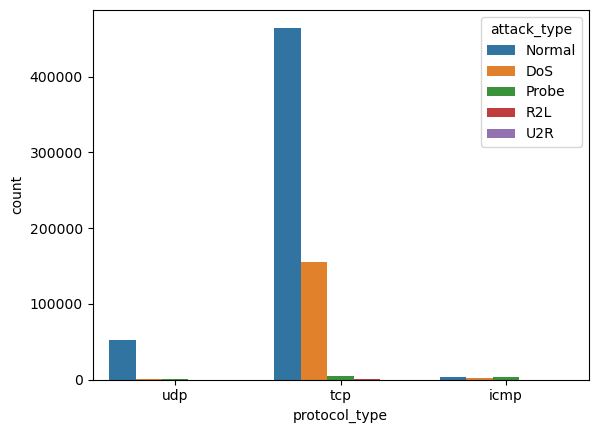

In [20]:
sns.countplot(x = 'protocol_type',hue = 'attack_type',data =set)
plt.show()

Guest Login vs Traffic status
Influence of guest login


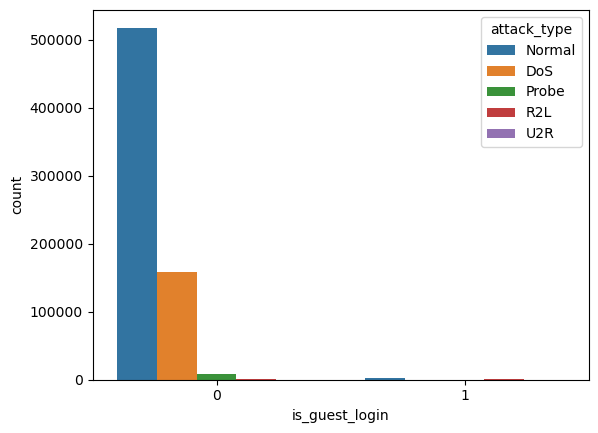

In [21]:
sns.countplot(x = 'is_guest_login',hue = 'attack_type',data = set)
print("Guest Login vs Traffic status")
print('Influence of guest login')
plt.show()

Land status vs Target


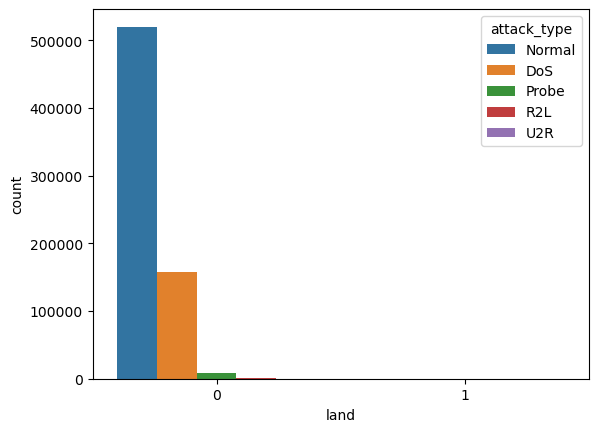

In [22]:
sns.countplot(x = 'land',hue = 'attack_type',data = set)
print("Land status vs Target")
plt.show()

In [23]:
# Convert `attack_type` to binary classes: 'Normal.' and 'attack'
data['attack_type'] = data['attack_type'].apply(lambda x: 'Normal' if x == 'Normal' else 'attack')

# Verify the transformation
print(data['attack_type'].value_counts())


attack_type
Normal    812812
attack    262169
Name: count, dtype: int64


Enhanced Category-wise graphical representation


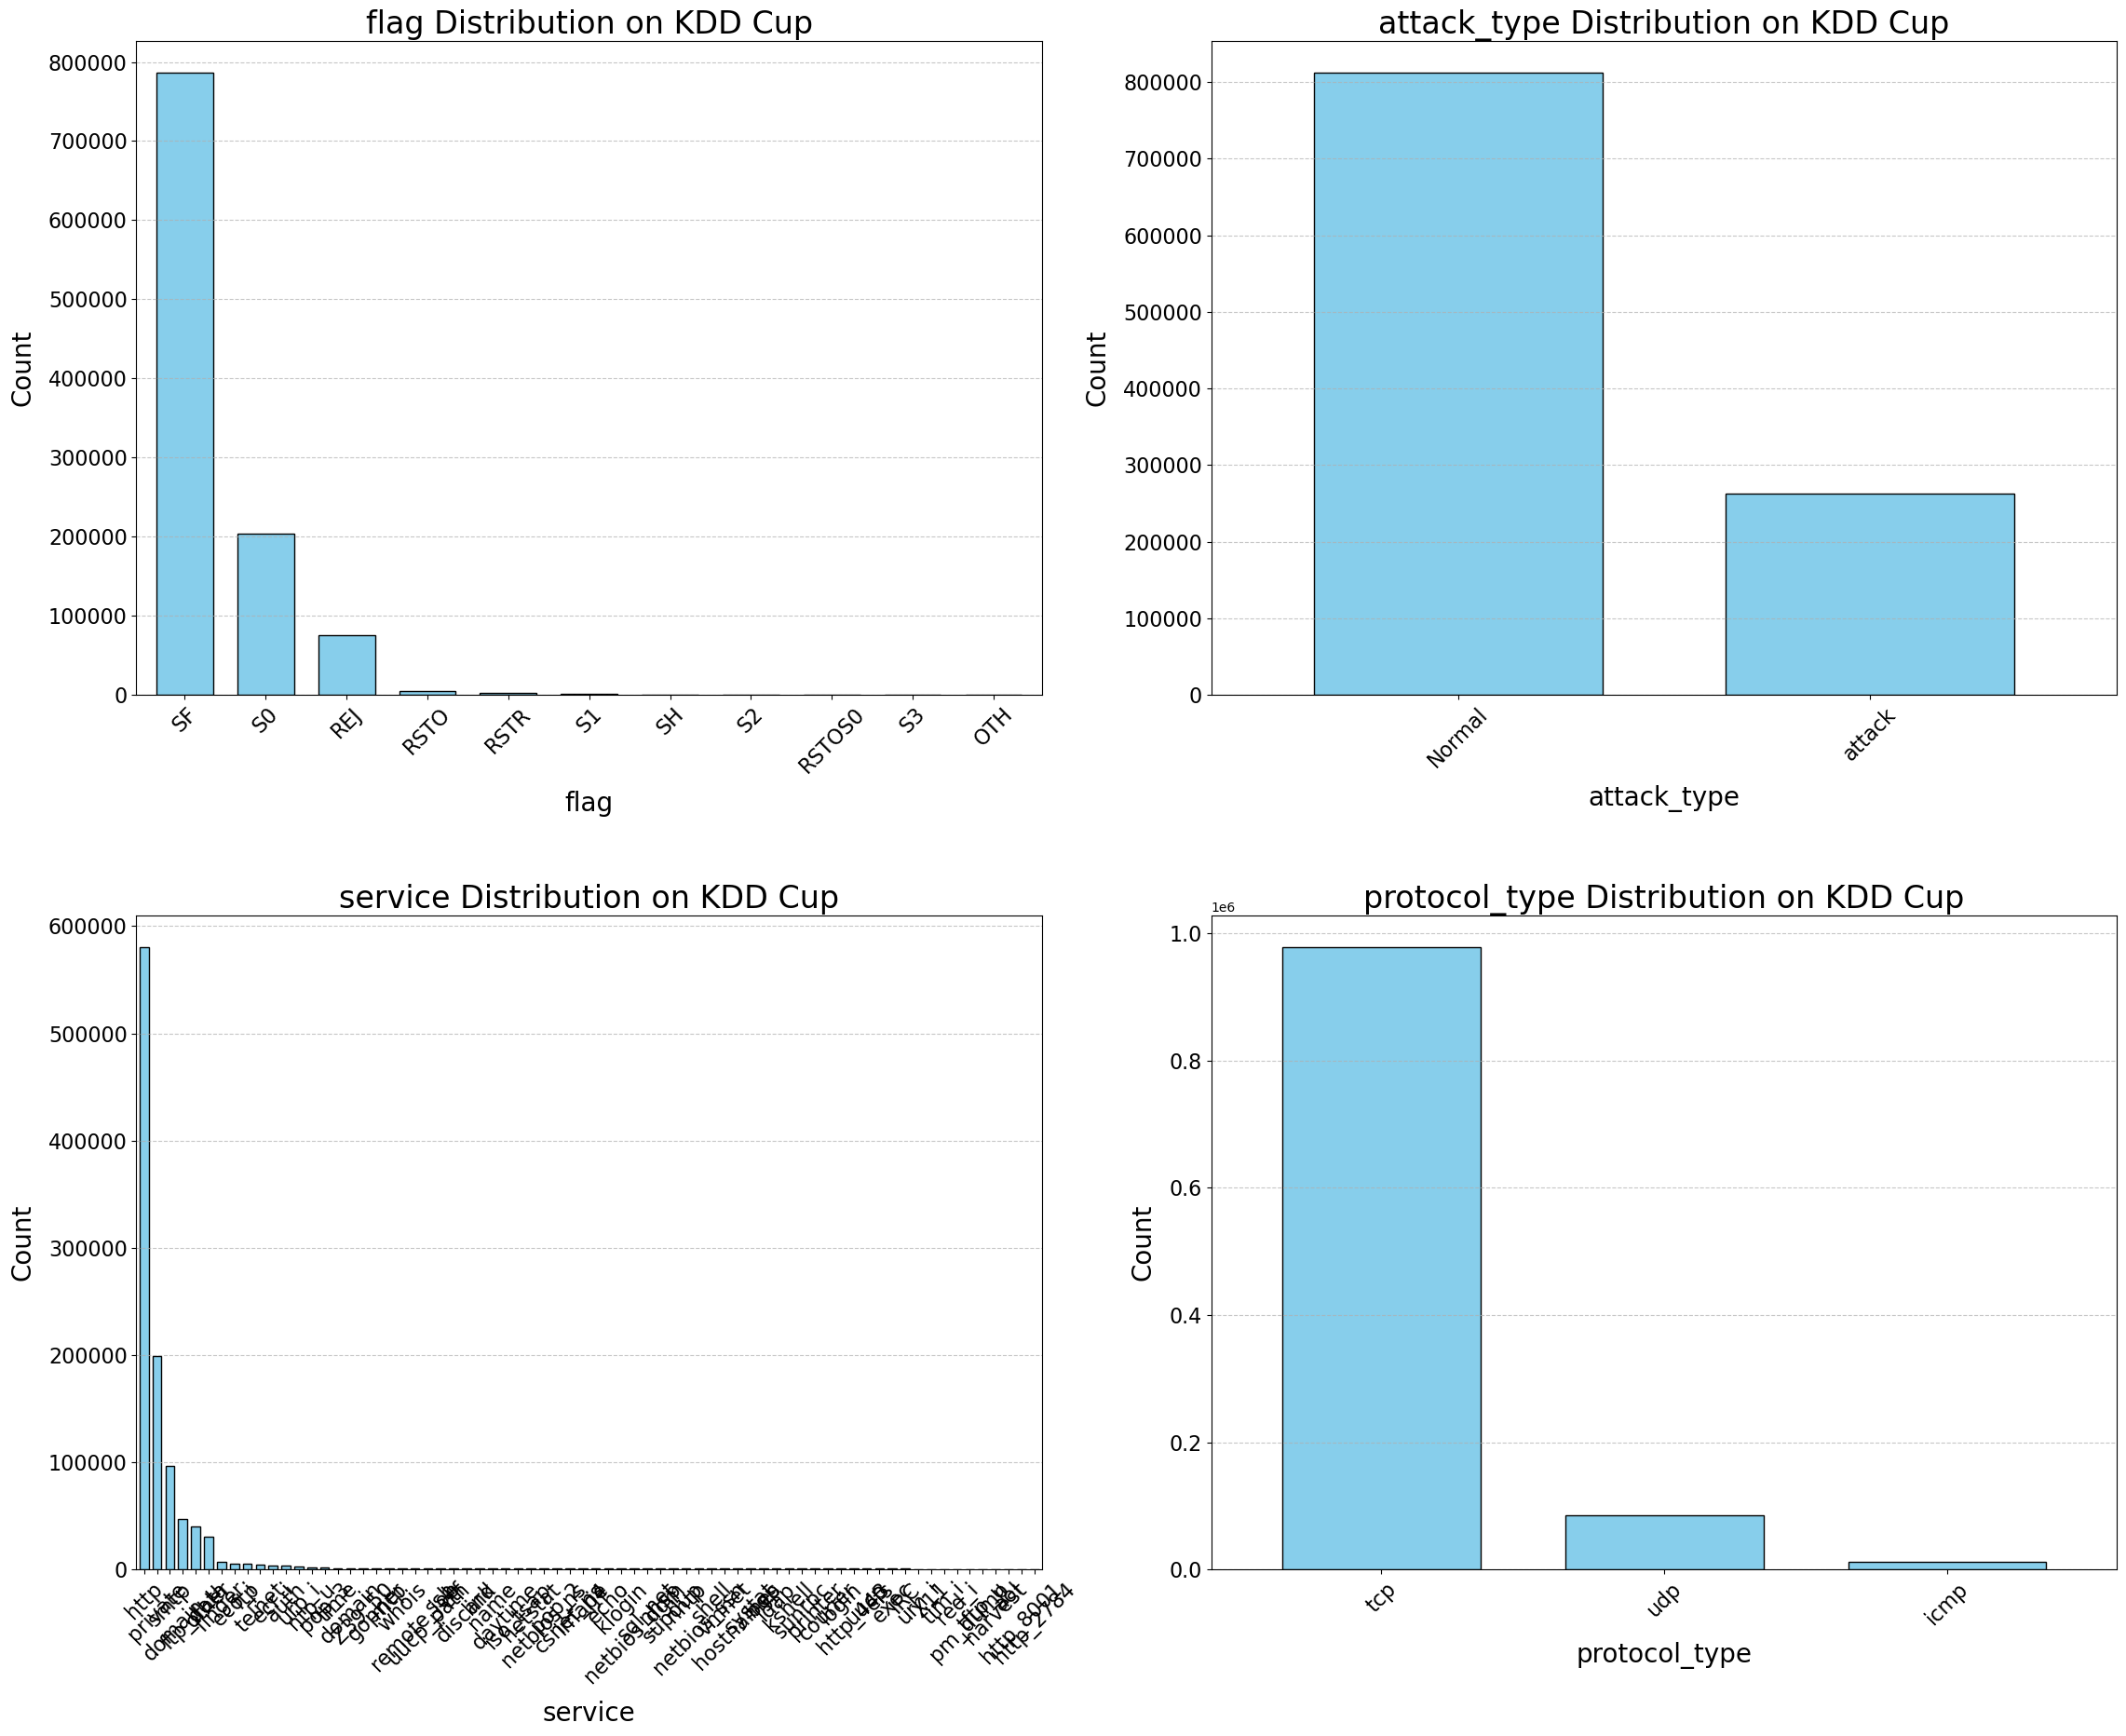

In [24]:
def plot_categorical_distributions(data, categorical_features):
    # Create a 2x2 grid for plotting
    fig, axes = plt.subplots(2, 2, figsize=(22, 20))
    fig.tight_layout(h_pad=15, w_pad=10, rect=[0, 0.08, 1, 0.93])

    # Iterate over the features and plot each in a separate subplot
    for i, feature in enumerate(categorical_features):
        row, col = divmod(i, 2)  # Determine subplot position
        value_counts = data[feature].value_counts()
        
        # Plot with additional clarity settings
        value_counts.plot(
            kind='bar',
            ax=axes[row][col],
            color='skyblue',
            edgecolor='black',  # Add edge color for clearer bars
            width=0.7  # Narrower bars for readability
        )
        
        # Set labels and title with larger fonts
        axes[row][col].set_xlabel(feature, fontsize=20, labelpad=10)
        axes[row][col].set_ylabel("Count", fontsize=20, labelpad=10)
        axes[row][col].set_title(f"{feature} Distribution on KDD Cup", fontsize=24)
        
        # Add gridlines and rotate x-axis labels
        axes[row][col].grid(axis='y', linestyle='--', alpha=0.7)
        axes[row][col].tick_params(axis='x', labelsize=16, rotation=45)
        axes[row][col].tick_params(axis='y', labelsize=16)

    print("Enhanced Category-wise graphical representation")
    plt.show()

# List of categorical features
categorical_features = ['flag', 'attack_type','service', 'protocol_type']

# Call the function with your dataset and the list of categorical features
plot_categorical_distributions(data, categorical_features)


<Axes: >

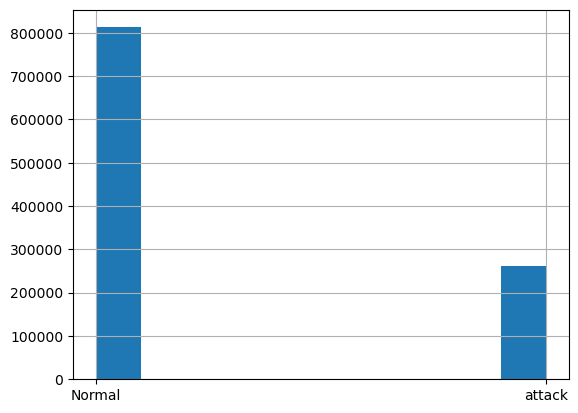

In [25]:
data['attack_type'].hist()

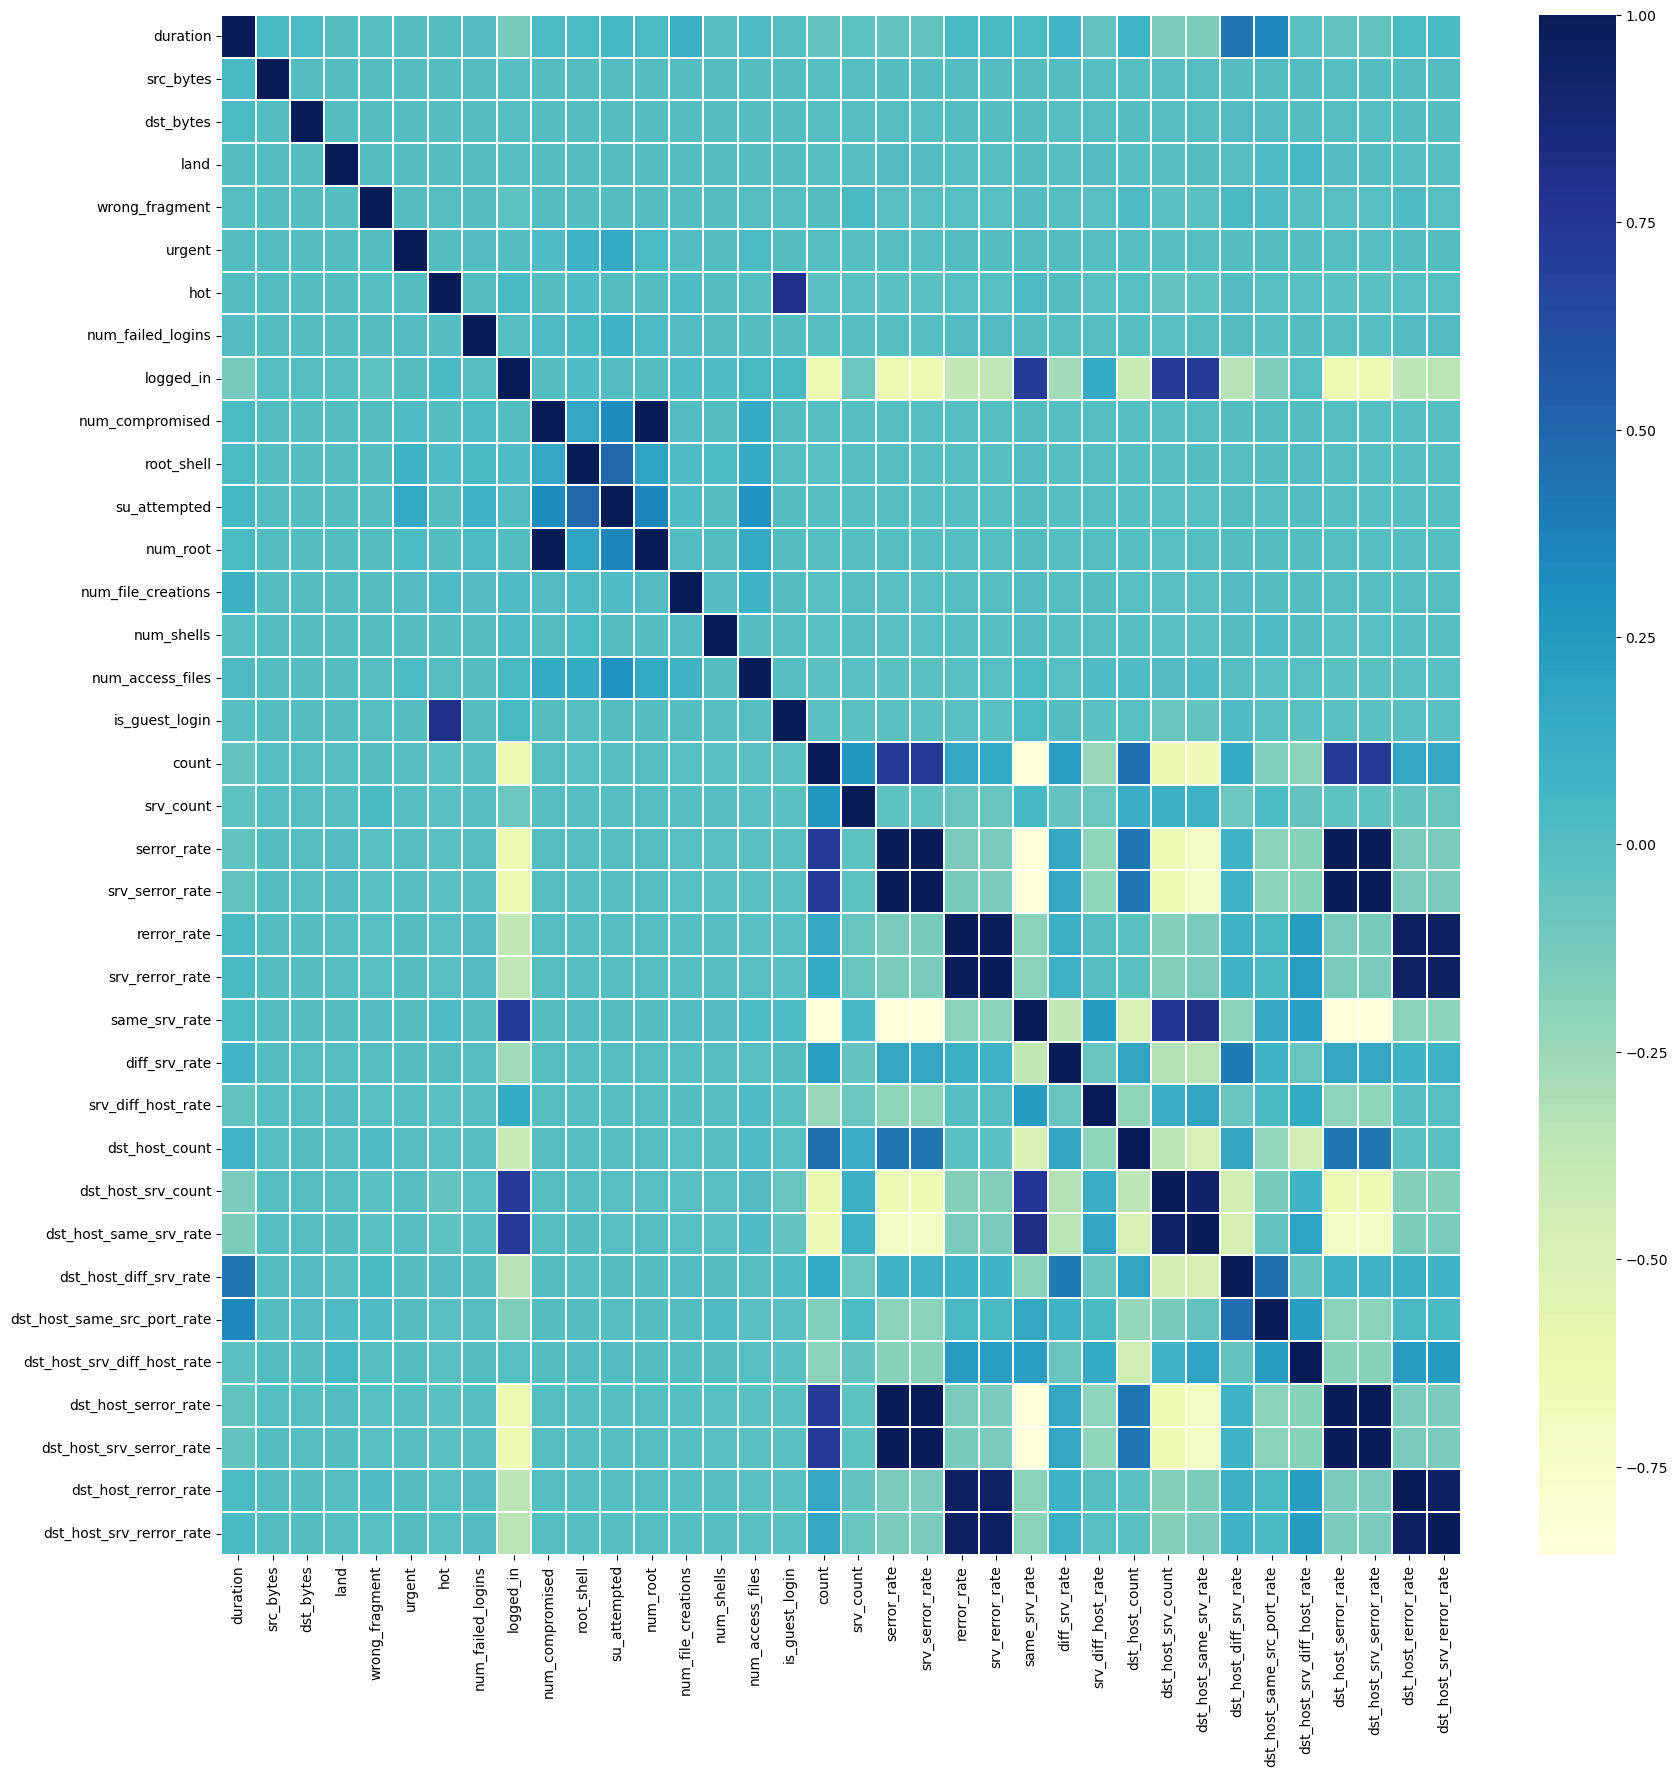

In [27]:
# Drop non-numeric columns for correlation calculation
numeric_data = set.drop(['num_outbound_cmds', 'is_host_login'], axis=1).select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr_matrix, ax=ax, cmap="YlGnBu", linewidths=0.1)
plt.show()

In [29]:
[TRANSLATED TEXT HERE]

1 Correlation = 0.9976014772964261
2 Correlation = 0.996829286448159
3 Correlation = 0.9895908774464132
4 Correlation = 0.9973893178098259
5 Correlation = -0.13893814548827013
6 Correlation = 0.9564016228544676
7 Correlation = 0.9585239360640544
8 Correlation = 0.9318137658121972


In [30]:
[TRANSLATED TEXT HERE]

In [31]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,attack_type
0,0,tcp,http,SF,162,4528,0,0,0,0,...,1.0,0.0,0.00,1,1,0.0,1.00,0.00,0.0,Normal
1,0,tcp,http,SF,236,1228,0,0,0,0,...,1.0,0.0,0.00,2,2,0.0,0.50,0.00,0.0,Normal
2,0,tcp,http,SF,233,2032,0,0,0,0,...,1.0,0.0,0.00,3,3,0.0,0.33,0.00,0.0,Normal
3,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.00,4,4,0.0,0.25,0.00,0.0,Normal
4,0,tcp,http,SF,238,1282,0,0,0,0,...,1.0,0.0,0.00,5,5,0.0,0.20,0.00,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898424,0,tcp,http,SF,212,2288,0,0,0,0,...,1.0,0.0,0.16,3,255,0.0,0.33,0.05,0.0,Normal
4898425,0,tcp,http,SF,219,236,0,0,0,0,...,1.0,0.0,0.15,4,255,0.0,0.25,0.05,0.0,Normal
4898426,0,tcp,http,SF,218,3610,0,0,0,0,...,1.0,0.0,0.15,5,255,0.0,0.20,0.05,0.0,Normal
4898427,0,tcp,http,SF,219,1234,0,0,0,0,...,1.0,0.0,0.14,6,255,0.0,0.17,0.05,0.0,Normal


In [32]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate
count,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,...,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06,1.074981e+06
mean,1.348922e+02,5.837599e+03,4.873736e+03,2.418647e-05,2.735862e-03,3.627971e-05,5.428003e-02,1.460491e-04,6.301209e-01,3.570854e-02,...,7.811768e-02,7.785640e-01,3.159983e-02,1.179051e-01,1.619740e+02,1.592108e+02,4.949942e-02,9.335021e-02,2.173624e-02,1.906599e-01
std,1.321612e+03,2.009627e+06,1.376873e+06,4.917917e-03,8.836031e-02,1.540170e-02,9.974669e-01,1.558120e-02,4.827720e-01,8.232138e+00,...,2.669238e-01,3.917213e-01,1.169092e-01,2.655134e-01,1.022638e+02,1.098836e+02,1.310807e-01,2.298153e-01,5.636334e-02,3.907636e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,5.000000e+01,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.190000e+02,3.320000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.240000e+02,2.480000e+02,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.060000e+02,1.721000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,1.000000e+00,1.000000e-02,9.000000e-02,2.550000e+02,2.550000e+02,6.000000e-02,4.000000e-02,2.000000e-02,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [33]:
# Define input features and target
X = data.iloc[:, :-1]  # All columns except the last one
y = data.iloc[:, -1]   # The last column (target)

In [34]:
# Frequency Encoding for 'service'
service_frequencies = X['service'].value_counts(normalize=True).to_dict()
X['service'] =X['service'].map(service_frequencies)

In [35]:
# Identify indices for 'protocol_type' and 'flag'
protocol_type_index = X.columns.get_loc('protocol_type')
flag_index = X.columns.get_loc('flag')

# ColumnTransformer with OneHotEncoder for 'protocol_type' and 'flag'
column_transformer = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(drop='first'), [protocol_type_index, flag_index])
    ],
    remainder='passthrough'  # Keep other columns unchanged
)

# Apply ColumnTransformer to X
X = column_transformer.fit_transform(X)



In [36]:
[TRANSLATED TEXT HERE]

In [37]:
# Encode target labels
label_encoder = LabelEncoder()
y= label_encoder.fit_transform(y)


In [38]:
if 'remainder__is_host_login' in X.columns:
    print('yup')
else:
    print("The column  does not exist in DataFrame X.")

yup


In [39]:
# Split the transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
def train_and_test_model(model,X_train,X_test,y_train,y_test,model_name):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    accuracy=accuracy_score(y_test,y_pred)
    conf_matrix=confusion_matrix(y_test, y_pred)
    print(f"\n{model_name}Results:")
    print(f"Accuracy:{accuracy:.4f}")
    print(f"Confusion matrix:\n",conf_matrix)

In [41]:
#1. Decision Tree Classifier
# 2. Random Forest Classifier
# 3. Naive Bayes Classifier
# 4. K-Nearest Neighbors Classifier
# 5. Support Vector Classifier (SVC)
train_and_test_model(DecisionTreeClassifier(random_state=42), X_train, X_test, y_train, y_test, "Decision Tree")
train_and_test_model(RandomForestClassifier(random_state=42), X_train, X_test, y_train, y_test, "Random Forest")
train_and_test_model(GaussianNB(), X_train, X_test, y_train, y_test, "Naive Bayes")
train_and_test_model(KNeighborsClassifier(n_neighbors=5), X_train, X_test, y_train, y_test, "KNeighbors")
train_and_test_model(LogisticRegression(), X_train, X_test, y_train, y_test, "logisticregression")
train_and_test_model(SVC(kernel='rbf'), X_train, X_test, y_train, y_test, "Support Vector")


Decision TreeResults:
Accuracy:0.9997
Confusion matrix:
 [[162479     31]
 [    30  52457]]

Random ForestResults:
Accuracy:0.9998
Confusion matrix:
 [[162501      9]
 [    25  52462]]

Naive BayesResults:
Accuracy:0.7739
Confusion matrix:
 [[161097   1413]
 [ 47189   5298]]

KNeighborsResults:
Accuracy:0.9993
Confusion matrix:
 [[162424     86]
 [    58  52429]]


C:\Users\Majd1\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



logisticregressionResults:
Accuracy:0.9668
Confusion matrix:
 [[157918   4592]
 [  2540  49947]]

Support VectorResults:
Accuracy:0.7559
Confusion matrix:
 [[162509      1]
 [ 52474     13]]
